In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pathlib
import time
import datetime
import numpy as np
import io_utils

from matplotlib import pyplot as plt
from IPython import display

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
from configuration import *
# print("DATASET_SIZE", DATASET_SIZE)
# print("TRAIN_SIZE", TRAIN_SIZE)
# print("TEST_SIZE", TEST_SIZE)

# np.random.seed(SEED)
# tf.random.set_seed(SEED)

In [4]:
# from dataset_utils import create_image_loader

# train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
# test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

# f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", False), num_parallel_calls=tf.data.AUTOTUNE)
# f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
# f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
# f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

# f2b_train_dataset = train_dataset.map(create_image_loader(2, 0, TRAIN_SIZES, "train", False), num_parallel_calls=tf.data.AUTOTUNE)
# f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
# f2b_test_dataset = test_dataset.map(create_image_loader(2, 0, TEST_SIZES, "test", False))
# f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)

# f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train", False), num_parallel_calls=tf.data.AUTOTUNE)
# f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
# f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test", False))
# f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

In [5]:
# from pix2pix_model import Pix2PixModel

# model = Pix2PixModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp", "patch", "unet")
# model.load_generator()
# model.load_discriminator()

## Generating fake/real images dataset

This uses the previously loaded model to generate a dataset of real/fake images using some generator/discriminator from some previously trained model.

In [6]:
from io_utils import delete_folder, ensure_folder_structure

SOURCE_IMAGES_PATH = os.sep.join([TEMP_FOLDER, "improving-pix2pix", "source"])
GENERATED_IMAGES_PATH = os.sep.join([TEMP_FOLDER, "improving-pix2pix", "fake"])
TARGET_IMAGES_PATH = os.sep.join([TEMP_FOLDER, "improving-pix2pix", "real"])


# delete_folder(SOURCE_IMAGES_PATH)
# delete_folder(GENERATED_IMAGES_PATH)
# delete_folder(TARGET_IMAGES_PATH)


# for ds_name in ["train", "test"]:
#     ensure_folder_structure(os.sep.join([SOURCE_IMAGES_PATH, ds_name]))
#     ensure_folder_structure(os.sep.join([GENERATED_IMAGES_PATH, ds_name]))
#     ensure_folder_structure(os.sep.join([TARGET_IMAGES_PATH, ds_name]))

#     print(f"Generating from {ds_name}")
#     dataset = model.train_ds if ds_name == "train" else model.test_ds
    
#     input_images = []
#     target_images = []
#     generated_images = []
#     discriminated_target_images = []
#     discriminated_generated_images = []

#     for i, (input_image, target_image) in dataset.enumerate():
#         # defines or creates the images
#         input_images.append(input_image)
#         target_images.append(target_image)
#         generated_image = model.generator(input_image, training=True)
#         generated_images.append(generated_image)
#         discriminated_target_images.append(model.discriminator([input_image, target_image], training=True))
#         discriminated_generated_images.append(model.discriminator([input_image, generated_image], training=True))
       
#         # save images to disk
#         tf.keras.utils.save_img(f"{os.sep.join([SOURCE_IMAGES_PATH, ds_name, str(i.numpy())])}.png", input_image[0])
#         tf.keras.utils.save_img(f"{os.sep.join([TARGET_IMAGES_PATH, ds_name, str(i.numpy())])}.png", target_image[0])
#         tf.keras.utils.save_img(f"{os.sep.join([GENERATED_IMAGES_PATH, ds_name, str(i.numpy())])}.png", generated_image[0])
        
#         # show only the first 5 in the notebook
#         if i < 5:
#             plt.figure(figsize=(16, 16*5))
#             for j, image in enumerate([input_image, target_image, generated_image]):
#                 plt.subplot(1, 5, j+1)
#                 plt.imshow(tf.squeeze(image) * 0.5 + 0.5, interpolation="nearest")
#                 plt.axis("off")

#             for j, image in enumerate([discriminated_target_images[-1], discriminated_generated_images[-1]]):
#                 plt.subplot(1, 5, j+4)
#                 plt.imshow(tf.squeeze(image) * 0.5 + 0.5, cmap="gray", vmin=0.0, vmax=1.0, interpolation="nearest")
#                 plt.axis("off")
#             plt.show()
        

## Experimenting with Different Models

In [7]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(
        filters,
        size,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result


def P2PDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    input = layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name="input_image")
    target = layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name="target_image")

    x = layers.concatenate([input, target])  # (batch_size, 64, 64, channels*2)


    down = downsample(8, 4, False)(x)  # (batch_size, 32, 32, 64)
    
    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(8, 2, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)

    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(16, 2, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)
    down = layers.Dropout(0.5)(down)
    
    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(16, 4, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)
    
    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(32, 2, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)
    down = layers.Dropout(0.5)(down)
    
    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(32, 4, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)
    
    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(64, 4, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)
    down = layers.Dropout(0.5)(down)
    
    down = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    down = layers.Conv2D(64, 3, strides=1, kernel_initializer=initializer)(down)
    down = layers.BatchNormalization()(down)
    down = layers.LeakyReLU()(down)
    
    zero_pad1 = layers.ZeroPadding2D()(down)  # (batch_size, 34, 34, 64)
    conv = layers.Conv2D(128, 4, strides=1,
                                 use_bias=False,
                                kernel_initializer=initializer)(zero_pad1)  # (batch_size, 31, 31, 128)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 128)
    last = layers.Conv2D(1, 4, strides=1,
                            kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[input, target], outputs=last)



candidate_discriminator = P2PDiscriminator()
candidate_discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 8)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 8)    1024        ['concatenate[0][0]']        

In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                                padding="same",
                                kernel_initializer=initializer,
                                use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result


def UnetDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    input = layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name="input_image")
    target = layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name="target_image")

    inputs = layers.concatenate([input, target])  # (batch_size, 64, 64, channels*2)
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 32, 32, 64)
        downsample(128, 4),  # (batch_size, 16, 16, 128)
        downsample(256, 4),  # (batch_size, 8, 8, 256)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
    ]

    last = layers.Conv2D(1, 3,
                                     strides=1,
                                     # padding="same",
                                     kernel_initializer=initializer,
                                     activation="tanh"
                                 )  # (batch_size, 32, 32, 4)

    x = inputs

    # downsampling e adicionando as skip-connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # camadas de upsampling e skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=[input, target], outputs=x)



candidate_discriminator = UnetDiscriminator()
candidate_discriminator.summary()
    

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64, 8)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 64)   8192        ['concatenate_1[0][0]']    

In [9]:
from custom_layers import MaxPoolingWithArgmax2D, MaxUnpooling2D


def downsample_segnet(inputs, filters, size, convolution_steps=2, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    x = inputs
    for i in range(convolution_steps):
        x = layers.Conv2D(
            filters,
            size,
            strides=1,
            padding="same",
            kernel_initializer=initializer)(x)

        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
    
    x, indices = MaxPoolingWithArgmax2D(pool_size=2)(x)
    # x, indices = tf.raw_ops.MaxPoolWithArgmax(input=x, ksize=[size, size], strides=[2, 2], padding="valid", Targmax=tf.dtypes.int32)
    return x, indices
    
    
def upsample_segnet(inputs, filters, size, convolution_steps=2, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    x, indices = inputs
    # print(f"x is {x}")
    # print(f"indices is {indices}")
    x = MaxUnpooling2D(size=2)([x, indices])
    # x = tfa.layers.MaxUnpooling2D(pool_size=size)([x, indices])
    
    for i in range(convolution_steps):
        x = layers.Conv2D(filters, size, strides=1,
                            padding="same",
                            kernel_initializer=initializer
                         )(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    if apply_dropout:
        x = layers.Dropout(0.5)(x)

    # print(f"shape of x after upsample: {tf.shape(x)}")
    return x

    
def SegNetDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    input = layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name="input_image")
    target = layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS], name="target_image")

    inputs = layers.concatenate([input, target])  # (batch_size, 64, 64, channels*2)
    
    output = downsample_segnet(inputs, 64, 4, 2),  # (batch_size, 32, 32, 64)
    x, indices0 = output[0][0], output[0][1]
    output = downsample_segnet(x, 128, 4, 1),  # (batch_size, 16, 16, 128)
    x, indices1 = output[0][0], output[0][1]
    output = downsample_segnet(x, 256, 4, 2),  # (batch_size, 8, 8, 256)
    x, indices2 = output[0][0], output[0][1]
    output = downsample_segnet(x, 512, 4, 1),  # (batch_size, 4, 4, 512)
    x, indices3 = output[0][0], output[0][1]
    # output = downsample_segnet(x, 512, 4, 3),  # (batch_size, 2, 2, 512)
    # x, indices4 = output[0][0], output[0][1]

    # x = upsample_segnet([x, indices4], 512, 4, 3, apply_dropout=True),  # (batch_size, 4, 4, 512)
    # # print()
    x = upsample_segnet([x, indices3], 256, 4, 3, apply_dropout=True),  # (batch_size, 8, 8, 512)
    # print()
    x = upsample_segnet([x, indices2], 128, 4, 3),  # (batch_size, 16, 16, 512)
    # print()
    x = upsample_segnet([x, indices1], 64, 4, 2),  # (batch_size, 32, 32, 256)

    last = layers.Conv2D(1, 3, strides=1,
                            padding="valid",
                            kernel_initializer=initializer,
                         # activation="tanh"
                        )
    # last = layers.Conv2D(1, 3,
    #                          strides=1,
    #                          # padding="same",
    #                          kernel_initializer=initializer,
    #                          activation="tanh"
    #                      )  # (batch_size, 32, 32, 4)

    
    x = last(x[0])

    return tf.keras.Model(inputs=[input, target], outputs=x)



# candidate_discriminator = SegNetDiscriminator()
# candidate_discriminator.summary()

Model: "atrous-disc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 concatenate_9 (Concatenate)    (None, 64, 64, 8)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 conv2d_111 (Conv2D)            (None, 64, 64, 128)  16512       ['concatenate_9[0][0]']

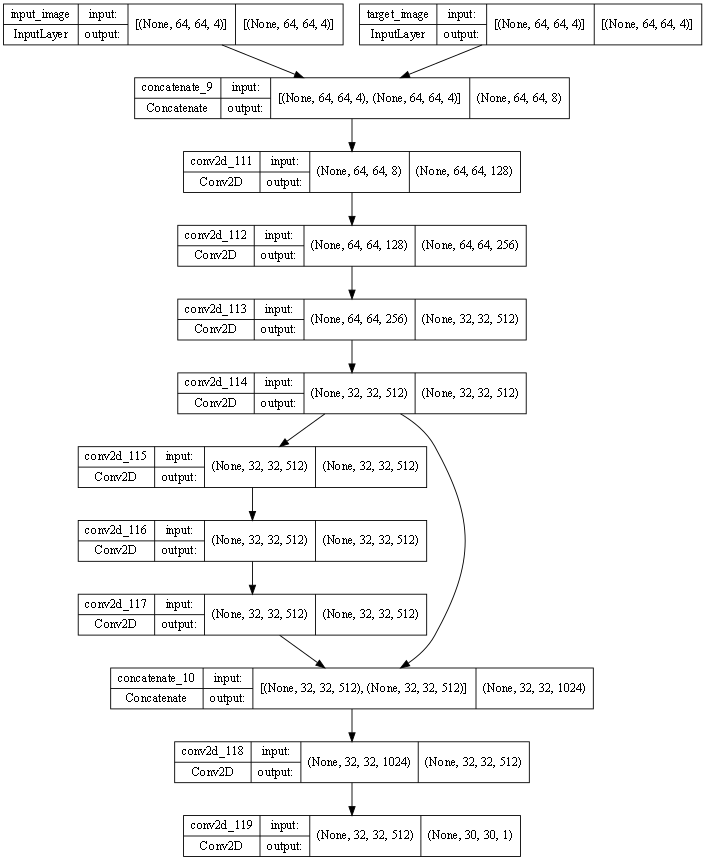

In [10]:
from pix2pix_model import SegnetDiscriminator, AtrousDiscriminator, UnetDiscriminator
candidate_discriminator = AtrousDiscriminator()
candidate_discriminator.summary()

tf.keras.utils.plot_model(candidate_discriminator, show_shapes=True, dpi=64)


In [11]:
normalization_layer = layers.Rescaling(1/127.5, offset=-1)

In [12]:
X = {"train": None, "test": None}

for ds_name in ["train", "test"]:
    source_images = tf.keras.utils.image_dataset_from_directory(os.sep.join([SOURCE_IMAGES_PATH, ds_name]), shuffle=False, labels=None, image_size=(IMG_SIZE, IMG_SIZE), color_mode="rgba").map(lambda img: normalization_layer(img)).unbatch()
    target_images = tf.keras.utils.image_dataset_from_directory(os.sep.join([TARGET_IMAGES_PATH, ds_name]), shuffle=False, labels=None, image_size=(IMG_SIZE, IMG_SIZE), color_mode="rgba").map(lambda img: normalization_layer(img)).unbatch()
    generated_images = tf.keras.utils.image_dataset_from_directory(os.sep.join([GENERATED_IMAGES_PATH, ds_name]), shuffle=False, labels=None, image_size=(IMG_SIZE, IMG_SIZE), color_mode="rgba").map(lambda img: normalization_layer(img)).unbatch()
    
    folder = os.sep.join([".", SOURCE_IMAGES_PATH, ds_name])
    number_of_examples = len([name for name in os.listdir(folder) if os.path.isfile(os.sep.join([folder, name]))])

    y_real = tf.ones((number_of_examples, 30, 30, 1))
    y_fake = y_real * 0.
    y_real = tf.data.Dataset.from_tensor_slices(y_real)#.repeat(number_of_examples)
    y_fake = tf.data.Dataset.from_tensor_slices(y_fake)#.repeat(number_of_examples)

    X_real = tf.data.Dataset.zip(((source_images, target_images), y_real))
    X_fake = tf.data.Dataset.zip(((source_images, generated_images), y_fake))

    X[ds_name] = X_real.concatenate(X_fake).shuffle(1000).batch(16)
    
X_train = X["train"]
X_test = X["test"]

Found 250 files belonging to 1 classes.
Found 250 files belonging to 1 classes.
Found 250 files belonging to 1 classes.
Found 44 files belonging to 1 classes.
Found 44 files belonging to 1 classes.
Found 44 files belonging to 1 classes.


In [13]:
# def scheduler(epoch, lr):
#     if epoch < 80:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)



candidate_discriminator.compile(
    tf.keras.optimizers.Adam(0.0002, beta_1=0.5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

epochs = 100
history = candidate_discriminator.fit(
    # X_test,
    X_train,
    validation_data=X_test,
    # callbacks=[callback],
    epochs=epochs
)

Epoch 1/100
32/32 [==============================] - 34s 797ms/step - loss: 0.7163 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 21s 637ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 21s 636ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 21s 636ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 21s 637ms/step - loss: 0.6970 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 21s 631ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 21s 636ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy:

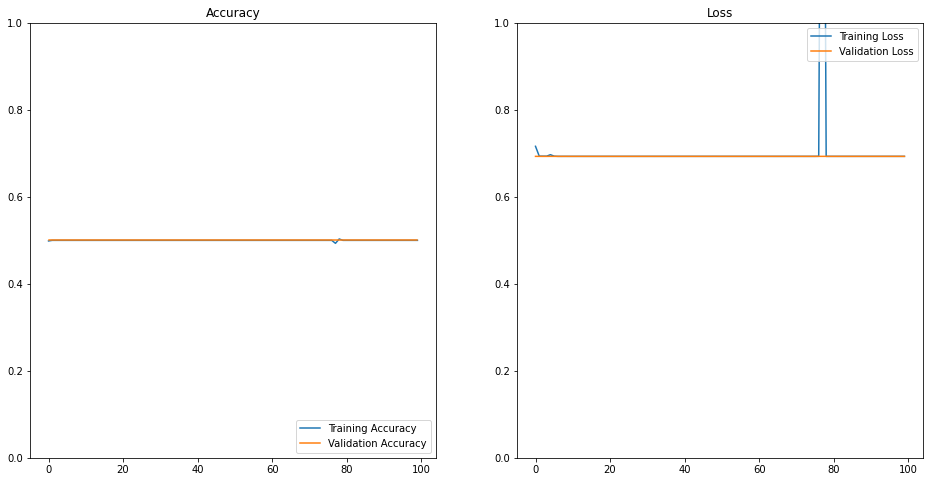

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8*2, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.ylim(ymin=0, ymax=1) 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.ylim(ymin=0, ymax=1) 
plt.show()